<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EA%B8%88%EC%9C%B5%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EC%BF%A1%EB%B6%81/1%EC%9E%A5_%EA%B8%88%EC%9C%B5_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
!pip install yfinance
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [181]:
import numpy as np
import pandas as pd
import yfinance as yf
import quandl
import intrinio_sdk as intrinio
from intrinio_sdk.rest import ApiException

import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.io as pio
pio.renderers.default = "colab"
import seaborn as sns 

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Load Data

## 야후 파이낸스에서 데이터 가져오기

In [4]:
df_yahoo = yf.download('AAPL', # ['AAPL', 'MSFT']
                       start='2011-01-01',
                       end='2021-12-31',
                       progress=False,
                       # auto_adjust=True, # 조정된 가격만 다운로드,
                       # actions='inline,' # 추가적으로 배당이나 액면 분할 정보를 다운로드,
                       # progress=False) # 진행 막대를 표시하지 않음

In [5]:
df_yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,11.630000,11.795000,11.601429,11.770357,10.063864,445138400
2011-01-04,11.872857,11.875000,11.719643,11.831786,10.116387,309080800
2011-01-05,11.769643,11.940714,11.767857,11.928571,10.199142,255519600
2011-01-06,11.954286,11.973214,11.889286,11.918929,10.190897,300428800
2011-01-07,11.928214,12.012500,11.853571,12.004286,10.263878,311931200


## 퀀들로 데이터 받기



In [17]:
NASDAQ_KEY = 'moGvN9TevWmyAKzhBX1C'
quandl.ApiConfig.api_key=NASDAQ_KEY

In [18]:
df_quandl = quandl.get(dataset='WIKI/AAPL',
                       start_date='2000-01-01', 
                       end_date='2010-12-31')

In [19]:
df_quandl.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


# 주가를 수익률로 변환

* **단순 수익률**
  * 자산에 대해 집계한다. 포트폴리오의 단순 수익률은 포트폴리오 내 개별 자산 수익률의 가중화 합신이다

* **로그 수익률**
  * 시간에 대해 집계한다. 예를 들어 주어진 달의 로그 수익률이란 그 달의 일중 수익률 로그의 합산이다

In [118]:
# 조정 종가만 남김
df = df_yahoo.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [119]:
df.head()

,adj_close
Date,
2011-01-03,10.063864
2011-01-04,10.116387
2011-01-05,10.199142
2011-01-06,10.190897
2011-01-07,10.263878


In [120]:
# 단순 수익률
df['simple_rtn'] = df.adj_close.pct_change() # pct_chage() : 현재와 이전 원소 사이의 백분율 변화를 계산

# 로그 수익률
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))

In [121]:
df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2011-01-03,10.063864,NaN,NaN
2011-01-04,10.116387,0.005219,0.005205
2011-01-05,10.199142,0.008180,0.008147
2011-01-06,10.190897,-0.000808,-0.000809
2011-01-07,10.263878,0.007161,0.007136


# 인플레이션 

In [108]:
df_all_dates = pd.DataFrame(index=pd.date_range(start='2011-01-01', 
                                                end='2021-12-31'))

df = df_all_dates.join(df[['adj_close']], how='left') \
                 .fillna(method='ffill') \
                 .asfreq('M')

In [109]:
# 인플레이션 데이터 로드
df_cpi = quandl.get(dataset='RATEINF/CPI_USA', 
                    start_date='2011-01-01', 
                    end_date='2021-12-31')
df_cpi.rename(columns={'Value':'cpi'}, inplace=True)

In [110]:
# 인플레이션 + 주가
df_merged = df.join(df_cpi, how='left')

In [111]:
# 단순 수익률
df_merged['simple_rtn'] = df_merged.adj_close.pct_change()

# 인플레이션율
df_merged['inflation_rate'] = df_merged.cpi.pct_change()

In [112]:
# 인플레이션에 따른 수익률
df_merged['real_rtn'] = (df_merged.simple_rtn + 1) / (df_merged.inflation_rate + 1) - 1
df_merged.head()

,adj_close,cpi,simple_rtn,inflation_rate,real_rtn
2011-01-31,10.361595,220.223,NaN,NaN,NaN
2011-02-28,10.785744,221.309,0.040935,0.004931,0.035827
2011-03-31,10.642225,223.467,-0.013306,0.009751,-0.022835
2011-04-30,10.691692,224.906,0.004648,0.006439,-0.001780
2011-05-31,10.621460,225.964,-0.006569,0.004704,-0.011220


# 빈도 변경

* 로그 수익률에 시간 주기 개수를 곱하거나 나눈다
* 변동성에 시간 주기 개수의 제곱근을 곱하거나 나눈다

In [113]:
# 실현 변동성
def realized_volatility(x):

  return np.sqrt(np.sum(x**2))

In [114]:
# 월별 실현 변동성을 계산
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn':'rv'}, inplace=True)

In [115]:
# 값을 연환산
df_rv.rv = df_rv * np.sqrt(12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


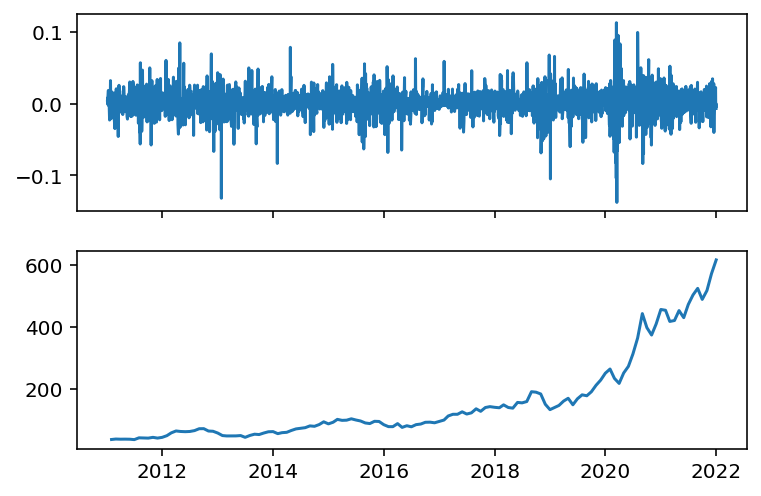

In [122]:
# 결과를 도식화
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df.log_rtn)
ax[1].plot(df_rv.rv)

# 시계열 데이터 시각화

## Mathplotlib

In [140]:
df = yf.download('MSFT',
                 start='2011-01-01',
                 end='2021-12-31',
                 auto_adjust = False,
                 progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [141]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))

In [142]:
df.dropna(how = 'any', inplace = True)

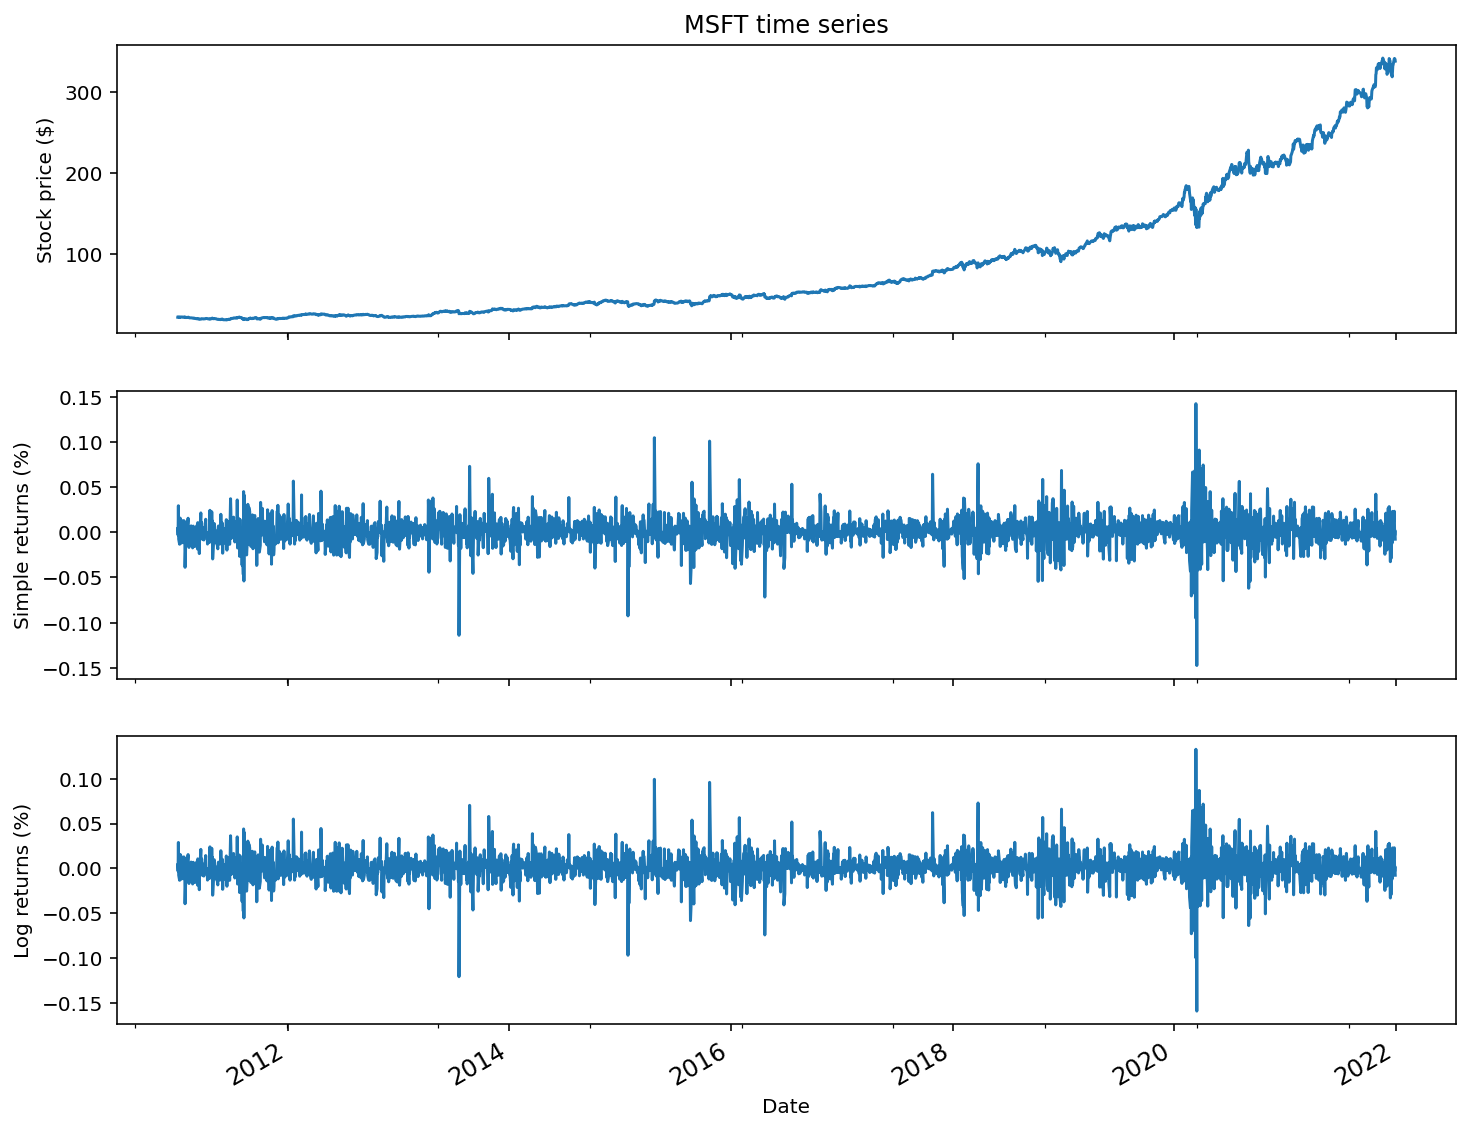

In [143]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 종가
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'MSFT time series',
          ylabel = 'Stock price ($)')

# 단순 수익률
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

# 로그 수익률
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', 
          ylabel = 'Log returns (%)')

ax[2].tick_params(axis='x', 
                  which='major', 
                  labelsize=12)

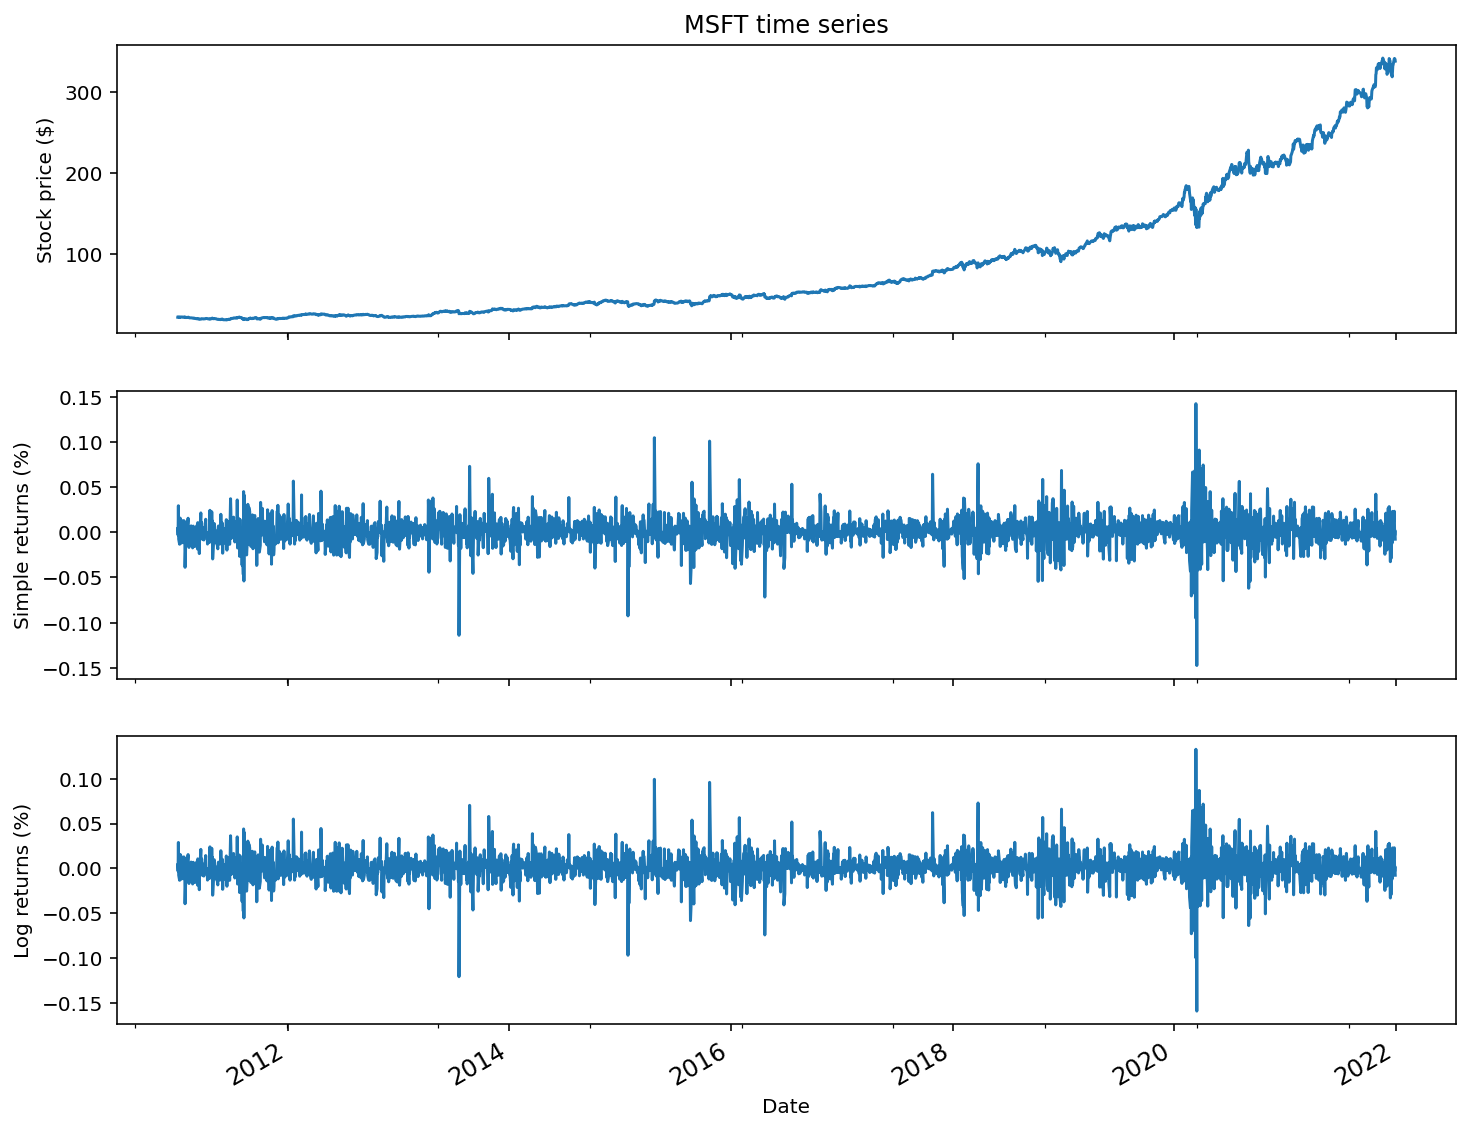

In [144]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# add prices
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'MSFT time series',
          ylabel = 'Stock price ($)')
    
# add simple returns 
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

# add log returns 
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', 
          ylabel = 'Log returns (%)')

ax[2].tick_params(axis='x', 
                  which='major', 
                  labelsize=12)


## Ploty & Cufflinks

In [175]:
df.iplot(subplots=True, shape=(3,1), shared_xaxes=True, title='MSFT time series')

# 이상치 식별

In [176]:
# 롤링 평균과 표준편차를 계산
df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [177]:
# 롤링 척도를 원시 데이터에 조인
df_outliers = df.join(df_rolling)

In [178]:
# 이상치 식별 함수 (기준 : 시그마 3)
def indentify_outliers(row, n_sigmas=3):

    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
        
    else:
        return 0 

In [179]:
# 이상치 값 추출
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

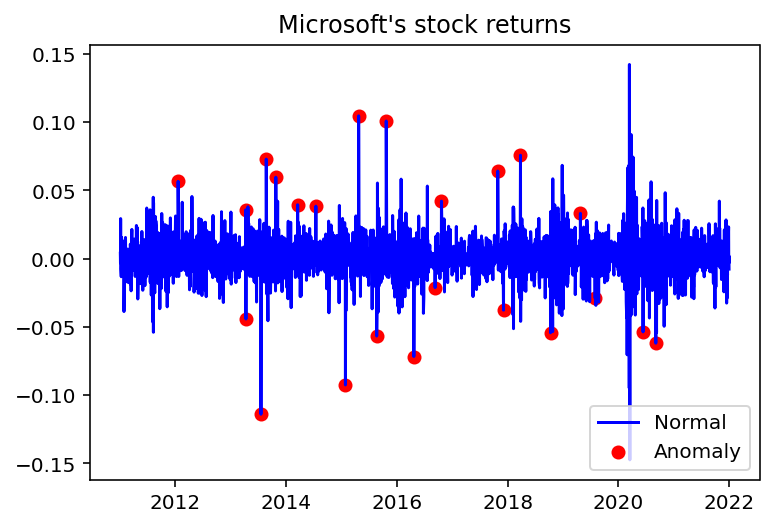

In [180]:
# 결과 도식화
fig, ax = plt.subplots()

# 단순 수익률
ax.plot(df_outliers.index, df_outliers.simple_rtn, color='blue', label='Normal')

# 이상치
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')

ax.set_title("Microsoft's stock returns")
ax.legend(loc='lower right')

plt.show()

# 자산 수익의 정형화된 사실 조사

In [182]:
# S&P 500
df = yf.download('^GSPC', 
                 start='1985-01-01', 
                 end='2021-12-31',
                 progress=False)

df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

df = df[['adj_close', 'log_rtn']].dropna(how = 'any')

In [183]:
df.head()

,adj_close,log_rtn
Date,,
1985-01-03,164.570007,-0.004849
1985-01-04,163.679993,-0.005423
1985-01-07,164.240005,0.003416
1985-01-08,163.990005,-0.001523
1985-01-09,165.179993,0.007230


## 수익률의 비정규 분포성

정규성이 아닌 것으로 추론

In [185]:
# 정규 분포 확률 밀도 함수 계산
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

음의 왜도 : 큰 음의 수익률은 큰 양의 수익률보다 자주 발생한다

초과 첨도 : 큰 수익률이 예상보다 더 자주 발생한다

경험적 분포가 정규 분포라면 대부분의 점이 빨간색 섬에 놓이게 됨

가우스 분포의 경우보다 도면의 왼쪽에 있는 점이 더 음의 값이 작기 때문에 정규성을 띄지 않다는 것을 볼 수 있다

  * 이는 수익률 분포의 왼쪽 꼬리가 가우스 분포의 꼬리보다 더 무겁다는 것을 의미
  * 오른쪽 꼬리를 통해 정규성보다 더 무겁다는 것을 유추할 수 있다

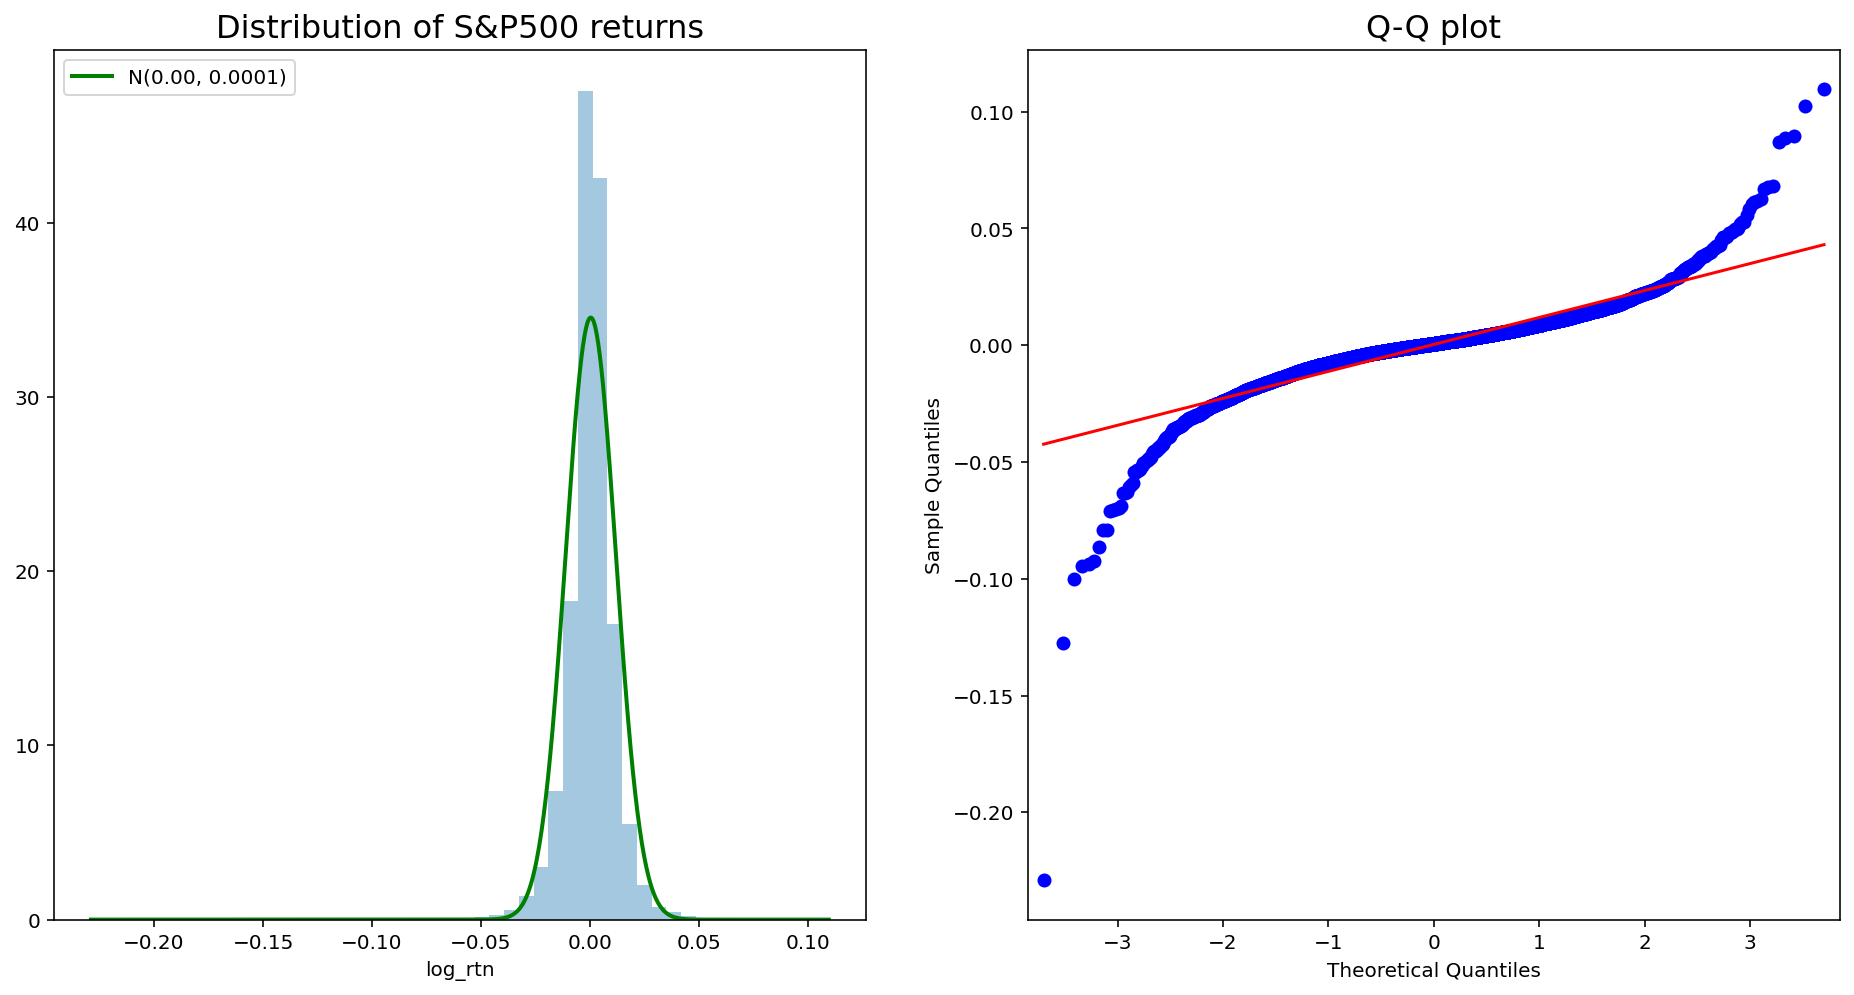

In [186]:
# 도식화
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 히스토그램
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])

ax[0].set_title('Distribution of S&P500 returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

plt.show()

자르케 - 베라 검정을 통해, p-값이 0이면 샘플 데이터가 가우스 분포와 일치하는 왜도와 첨도를 가진다는 귀무가설을 기각한다

In [187]:
# 요약 통계량
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}') # 왜도
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') # 첨도
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}') # 자르케 베라 정규성 검정

---------- Descriptive Statistics ----------
Range of dates: 1985-01-03 - 2021-12-30
Number of observations: 9325
Mean: 0.0004
Median: 0.0007
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0115
Skewness: -1.2488
Kurtosis: 26.9858
Jarque-Bera statistic: 285054.57 with p-value: 0.00


## 변동성 클러스터링

높은 양의 수익률과 음의 수익률의 변동성 클러스터가 보임

높은 수익률 기간은 낮은 수익률 기간과 교대로 나타나며, 변동성이 일정하지 않음을 나타낸다

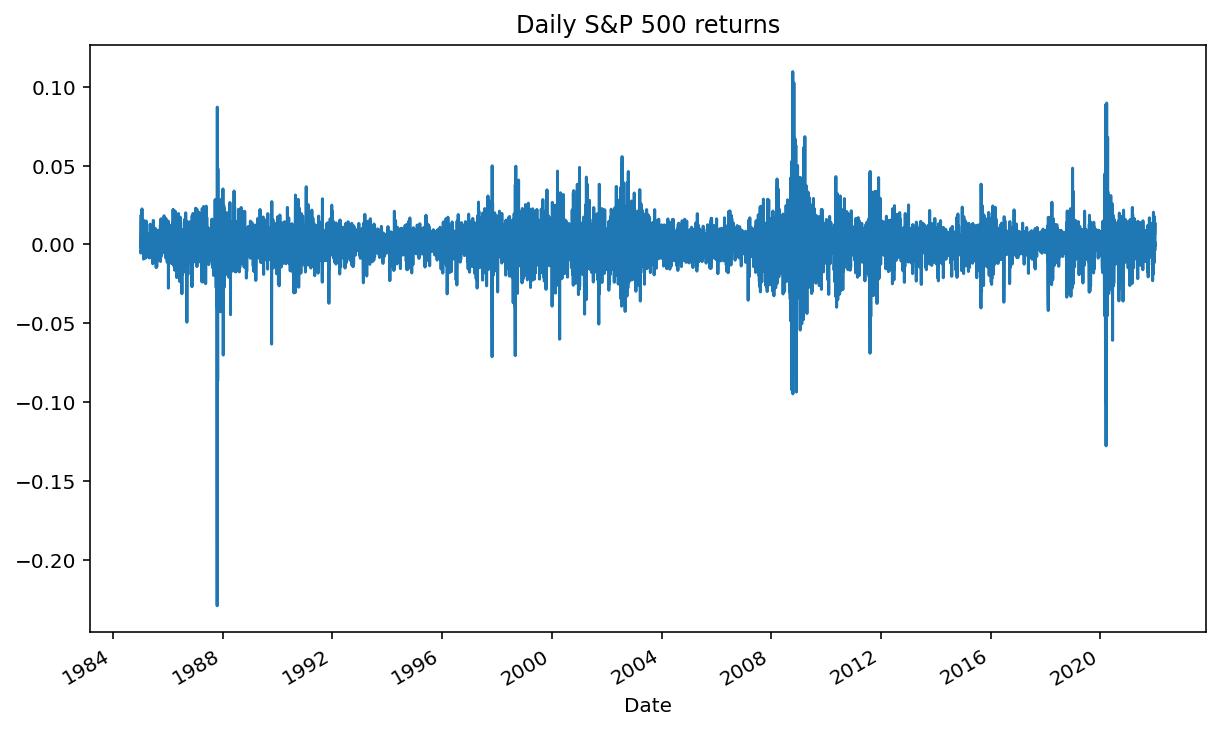

In [188]:
df.log_rtn.plot(title='Daily S&P 500 returns', figsize=(10, 6))

plt.show()

## 수익률의 자기 상관 부재

자기 상관은 연속된 시간 간격 동안 주어진 시계열이 자기 자신의 지연 버전과 비교해 얼마나 유사한지 측정한다 

신뢰 구간을 벗어나는 값은 몇 개 뿐이기에 통계적으로 유의미한 것으로 볼 수 있다

로그 수익률 시계열에서 자기 상관관계가 없는 것으로 확인됐다고 가정할 수 있음

In [189]:
N_LAGS = 50 # 50개의 지연 
SIGNIFICANCE_LEVEL = 0.05 # 신뢰구간 95%

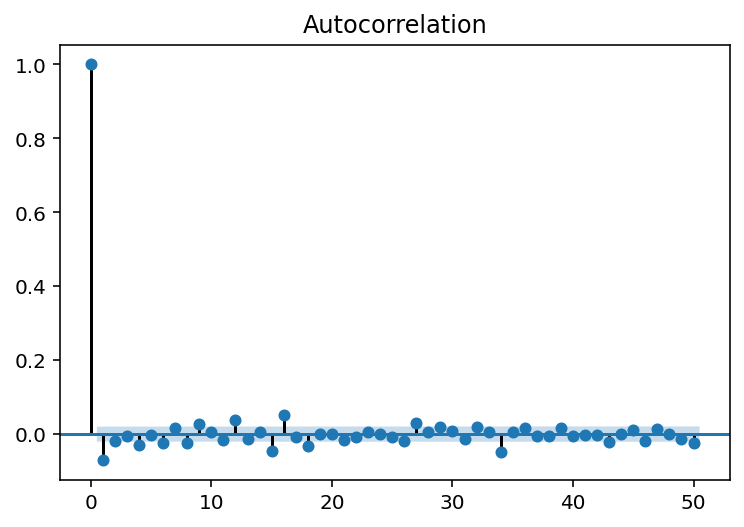

In [190]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

plt.show()

## 제곱/절대 수익률에서의 작고 감소하는 자기 상관

제곱과 절대 수익률에 대한 자기 상관관계의 작고 감소하는 값을 관찰할 수 있다

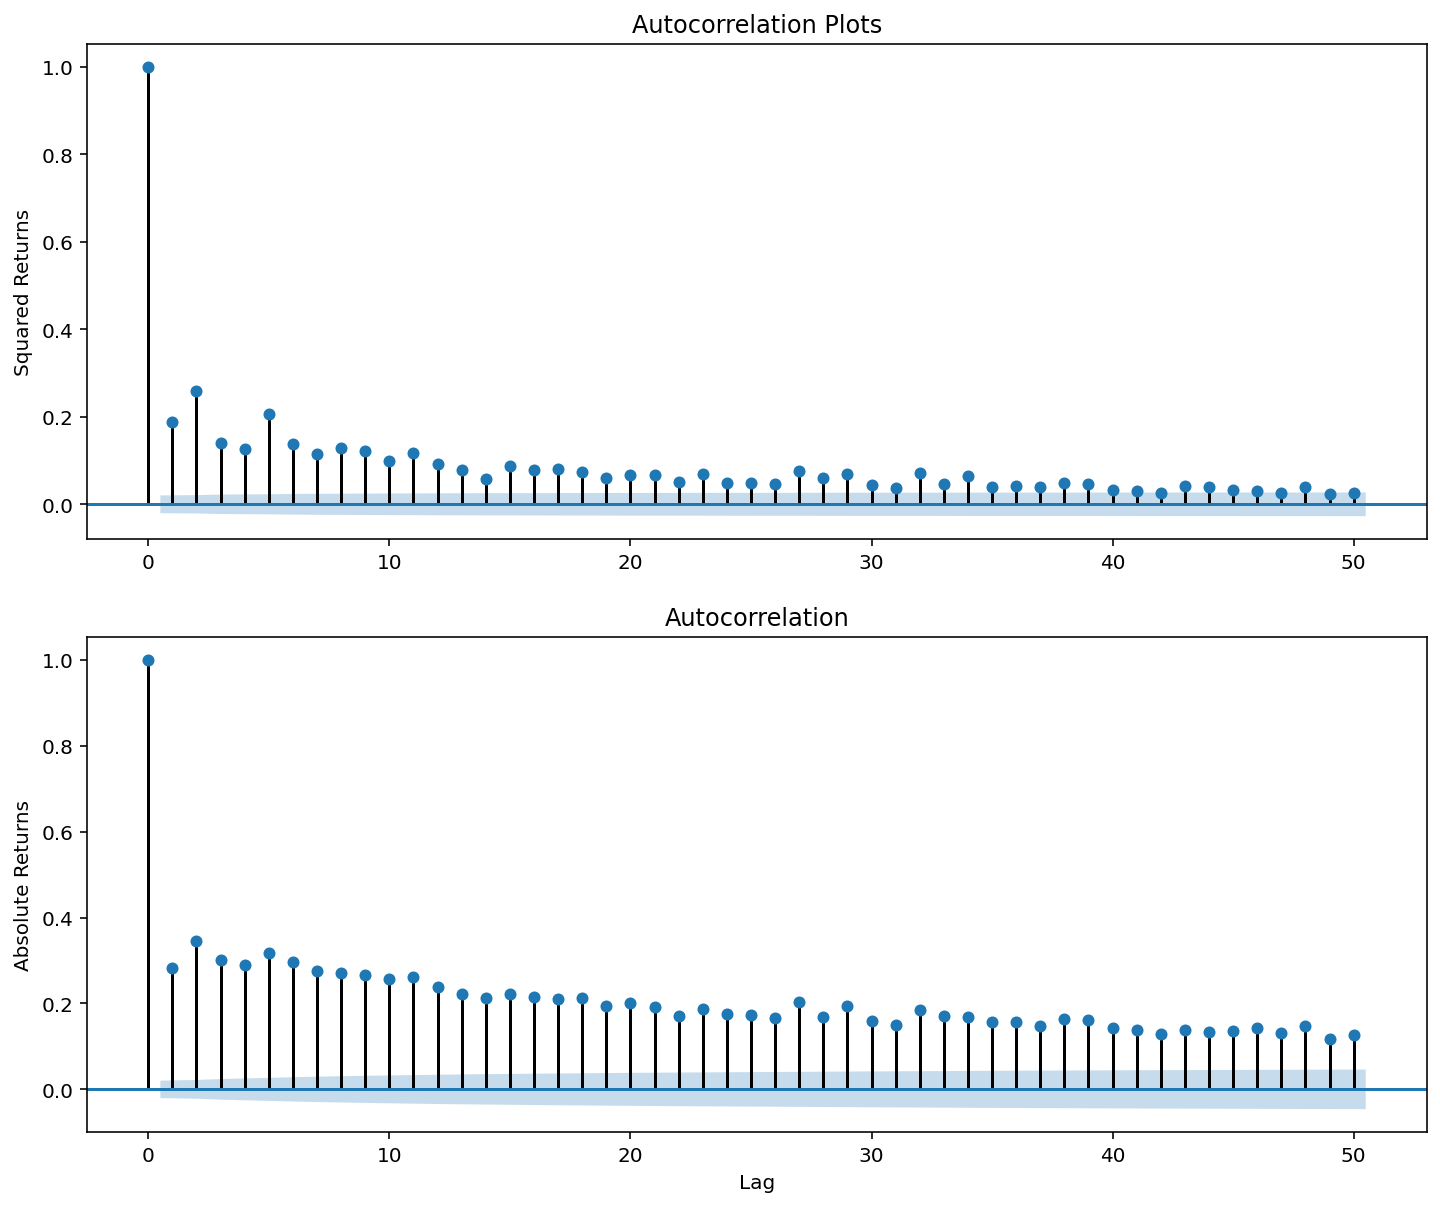

In [191]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# 제곱 수익률
smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[0])

ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')

# 절대 수익률
smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

plt.show()

## 레버리지 효과

### 이동 표준 편차

자산의 변동성에 대한 대부분의 측정치가 수익률과 음의 상관관계가 있음

가격이 하락하면 변동성이 증가하고, 가격이 상승하면 변동이 감소하는 패턴이 존재

In [192]:
# 변동성 척도로 롤링 표준편차로 계산
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std() # 1년 거래 데이터
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std() # 1개월 거래 데이터

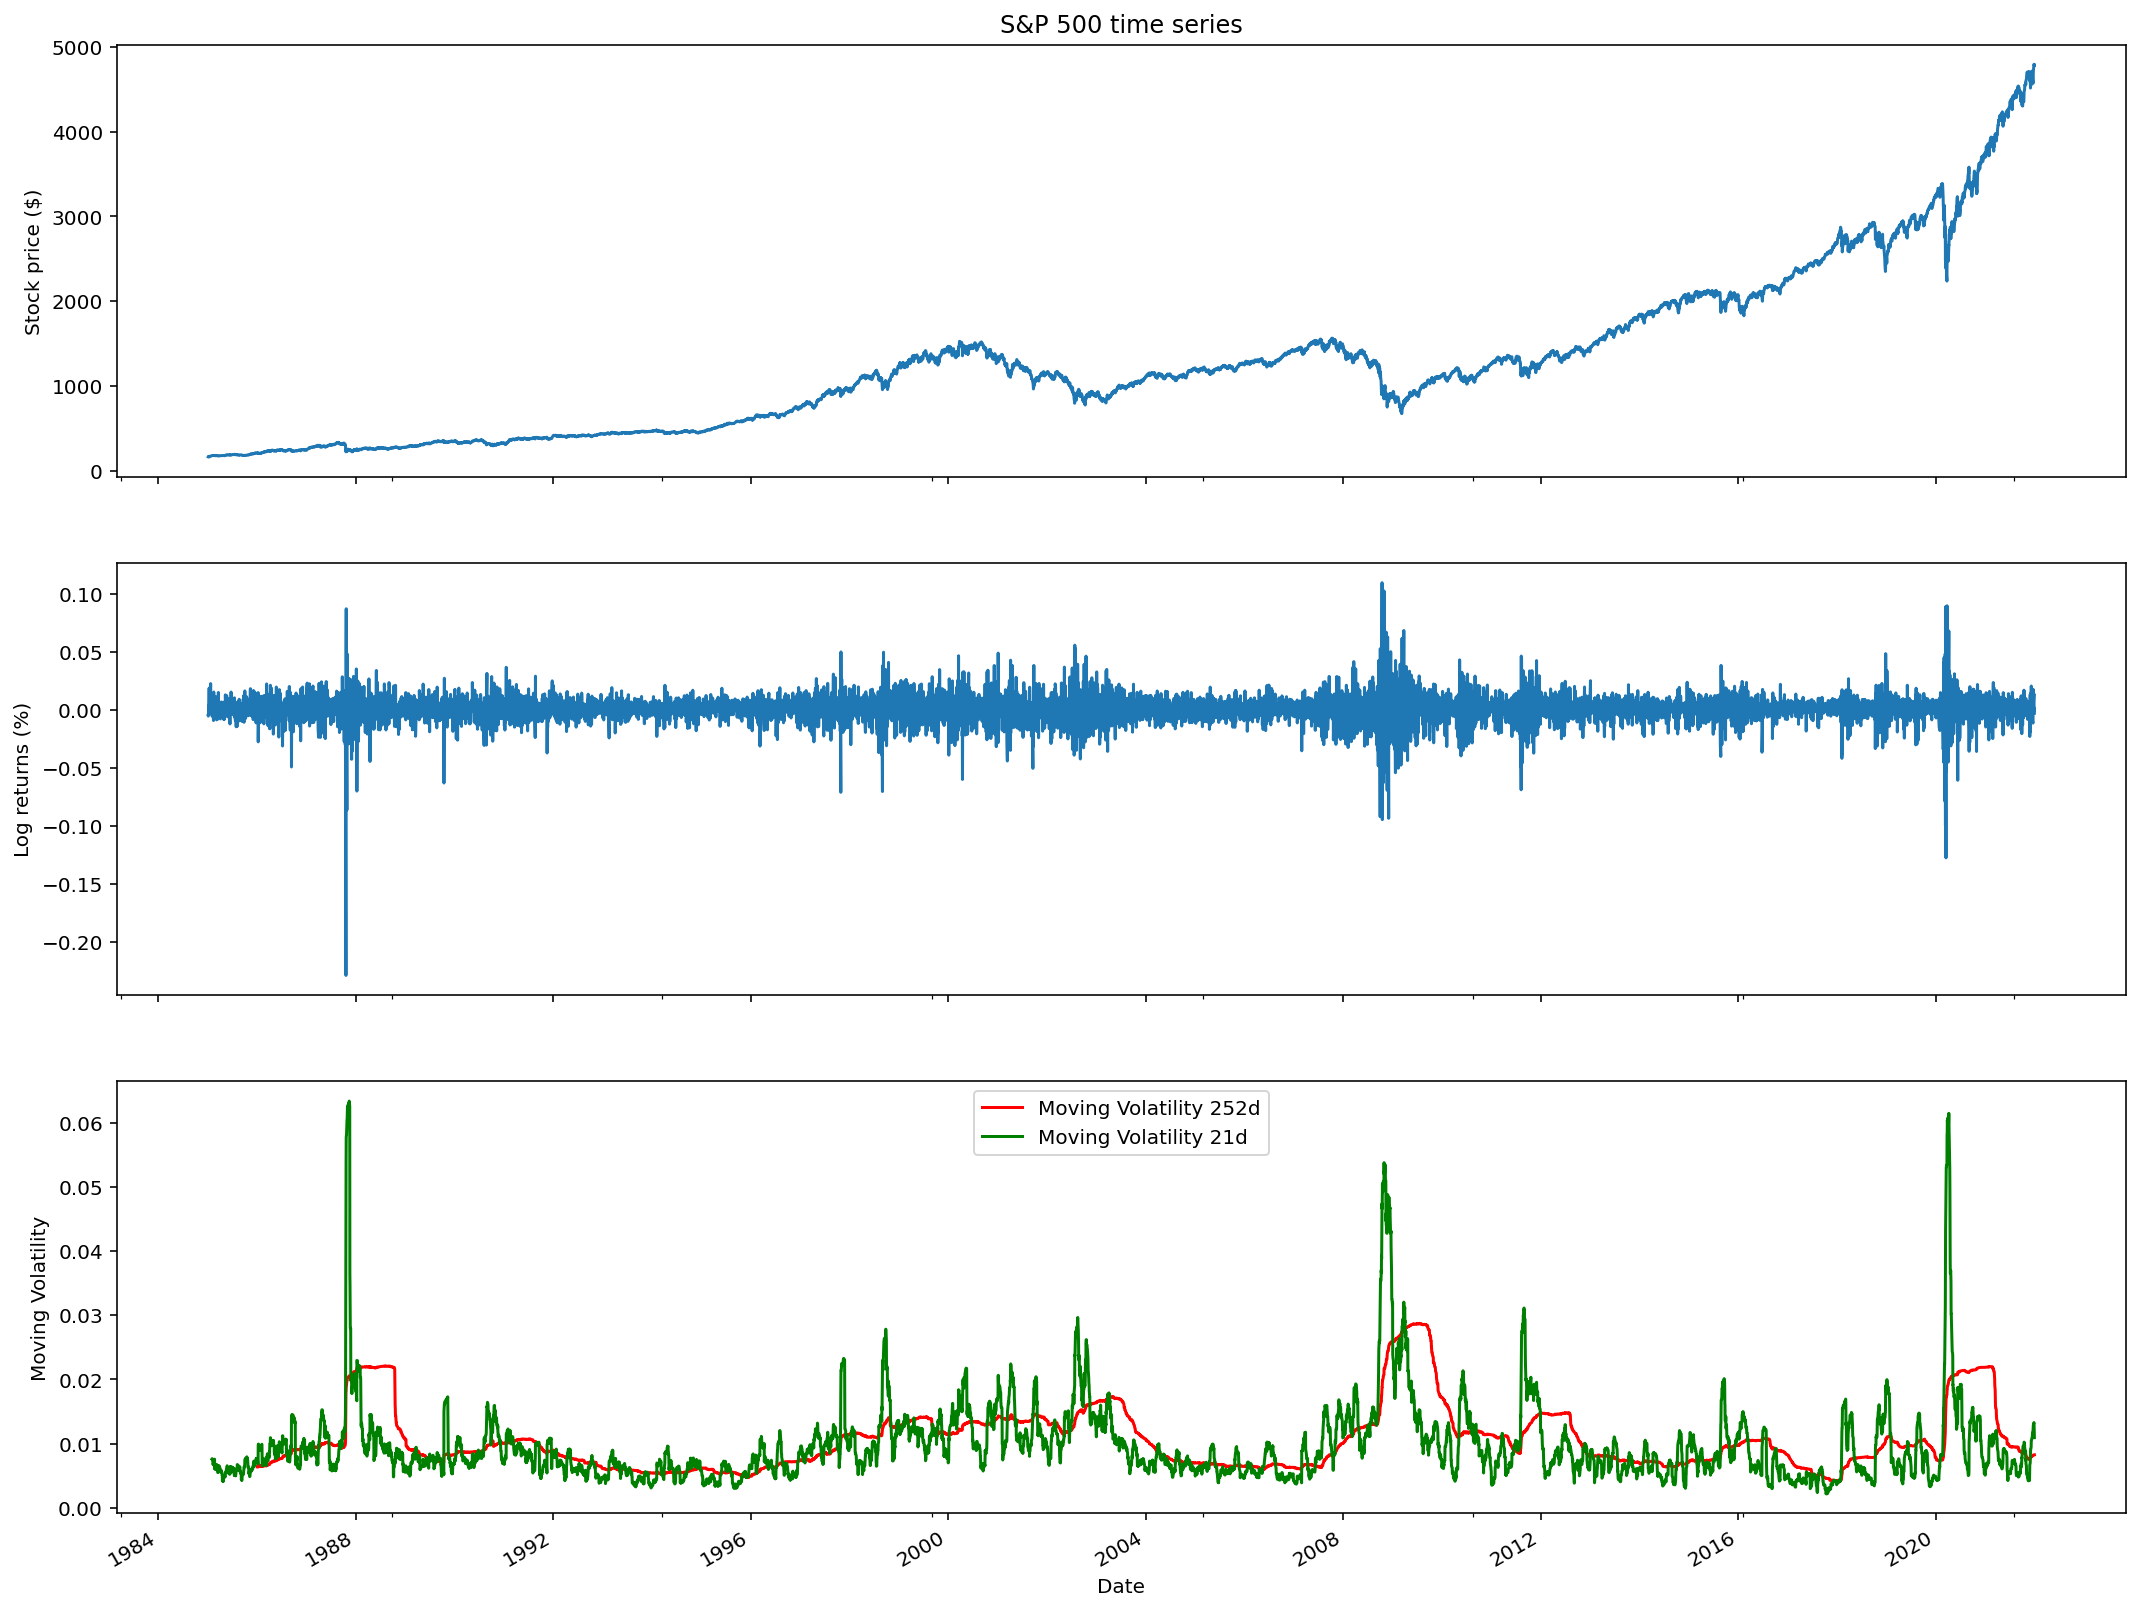

In [193]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

# 종가
df.adj_close.plot(ax=ax[0])
ax[0].set(title='S&P 500 time series',
          ylabel='Stock price ($)')

# 로그 수익률
df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log returns (%)')

# 변동성
df.moving_std_252.plot(ax=ax[2], color='r', 
                       label='Moving Volatility 252d')

df.moving_std_21.plot(ax=ax[2], color='g', 
                      label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility',
          xlabel='Date')

ax[2].legend()

plt.show()

### VIX (CBOE 변동성 지수)

회귀선의 음의 기울기와 함께 두 계열 간에 강한 음의 상관관계가 보임

이는 수익률 계열에 레버리지 효과가 있다는 것을 확인시켜줌

In [194]:
# S&P 500
df = yf.download(['^GSPC', '^VIX'], 
                 start='1985-01-01', 
                 end='2021-12-31',
                 progress=False)

df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC': 'sp500', '^VIX': 'vix'})

In [195]:
df['log_rtn'] = np.log(df.sp500 / df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix / df.vix.shift(1))
df.dropna(how='any', axis=0, inplace=True)

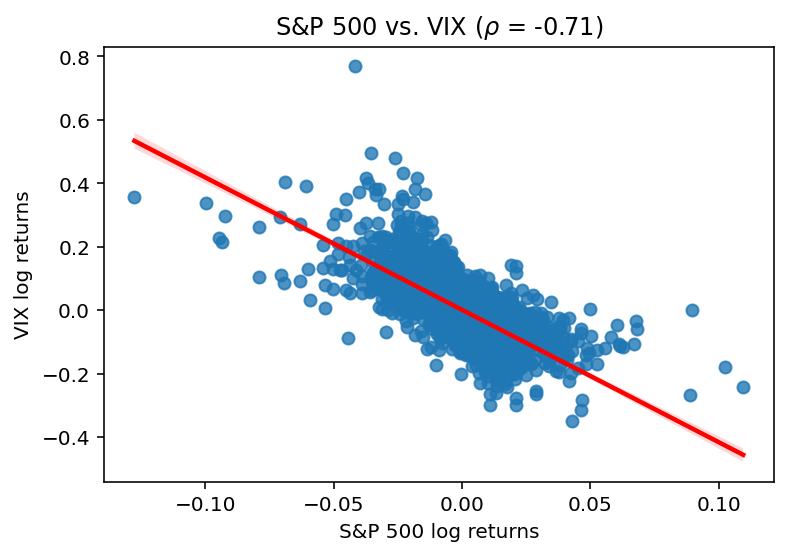

In [196]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df, 
                 line_kws={'color': 'red'})

ax.set(title=f'S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})',
       ylabel='VIX log returns',
       xlabel='S&P 500 log returns')

plt.show()